In [1]:
import nest_asyncio
nest_asyncio.apply()
import cmdstanpy as sp
import numpy as np
from scipy.optimize import curve_fit
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import arviz as az

In [2]:
data = pd.read_csv("linear_model.txt",delimiter='\t',header=None)
data.columns=['x','y','dy']

In [3]:
def f(x,a,b):
    return a*np.cos(x)+b
popt, pcov = curve_fit(f,data['x'].values,data['y'].values,p0=[2,2],sigma=data['dy'].values)

In [4]:
model = sp.CmdStanModel(stan_file='./stan_file.stan')

INFO:cmdstanpy:compiling stan program, exe file: /Users/jakob/Documents/Studium/master_thesis/bayes/stan_file
INFO:cmdstanpy:compiler options: stanc_options={}, cpp_options={}
INFO:cmdstanpy:compiled model file: /Users/jakob/Documents/Studium/master_thesis/bayes/stan_file


In [5]:
stan_data={'n':len(data['x'].values),
             'x':list(data['x'].values),
             'y':list(data['y'].values),
           'dy':list(data['dy'].values)
}

fit = model.sample(data=stan_data,chains=4)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 2


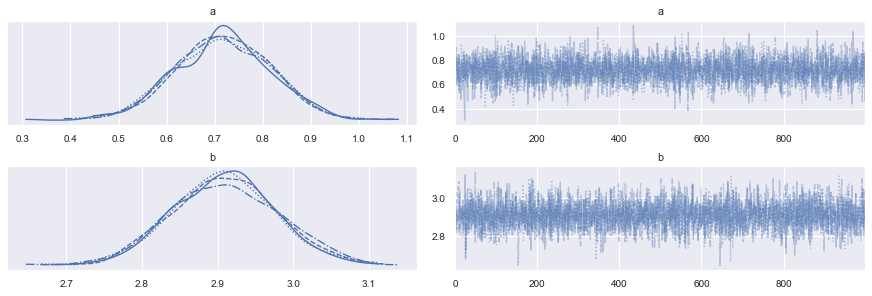

In [11]:
az.plot_trace(fit)
plt.show()

In [27]:
summary=az.summary(fit)
samples=fit.draws_pd()
samples
#to do: quantile aus a und b (0.1 und 0.9) ->plotten

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,a,b
0,-1.876070,0.935675,0.874886,2.0,3.0,0.0,1.931180,0.862640,2.92938
1,-1.348510,1.000000,0.874886,1.0,1.0,0.0,1.812310,0.821838,2.93070
2,-0.712873,1.000000,0.874886,2.0,3.0,0.0,1.305670,0.711524,2.92030
3,-0.705617,0.997843,0.874886,1.0,3.0,0.0,0.734024,0.708941,2.90364
4,-0.705617,0.619615,0.874886,1.0,3.0,0.0,3.723110,0.708941,2.90364
...,...,...,...,...,...,...,...,...,...
3995,-1.112180,0.983194,0.928948,2.0,3.0,0.0,1.551470,0.629690,2.93381
3996,-1.454620,0.925362,0.928948,2.0,3.0,0.0,1.964590,0.643636,2.98278
3997,-1.514910,0.973417,0.928948,2.0,3.0,0.0,2.105690,0.841758,2.88905
3998,-4.355860,0.728418,0.928948,2.0,7.0,0.0,4.795140,0.453425,2.88322


In [38]:
trace_thing=[]
for i in range(len(samples)):
    trace_thing.append(samples['a'][i]*np.cos(data['x'].values)+samples['b'][i])


/usr/local/lib/python3.9/site-packages/arviz/stats/stats.py:493: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


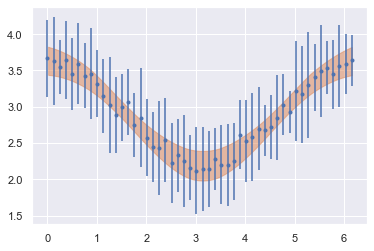

In [45]:
plt.errorbar(x=data['x'],y=data['y'],yerr=data['dy'],fmt='.')
az.plot_hdi(data['x'].values,trace_thing,hdi_prob=.90)
plt.show()

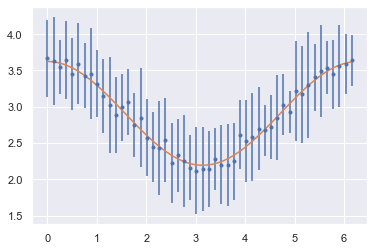

array([0.7158152 , 2.90910924])

In [7]:
yfit=f(data['x'],*popt)
plt.errorbar(x=data['x'],y=data['y'],yerr=data['dy'],fmt='.')
plt.plot(data['x'],yfit)
plt.show()
popt

In [8]:
az.summary(fit)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,0.717,0.098,0.531,0.896,0.002,0.001,3031.0,3031.0,3020.0,2617.0,1.0
b,2.909,0.069,2.775,3.036,0.001,0.001,3349.0,3349.0,3349.0,2603.0,1.0
